In [ ]:
# Run if dependencies are not installed
# !pip3 install -r torch datasets av

In [ ]:
!pip3 install matplotlib

In [1]:
%matplotlib inline

import sys
sys.path.append("..")

import matplotlib.pyplot as plt
import numpy as np

from egowalk_dataset.datasets.gnm.gnm_indexing import index_gnm
from egowalk_dataset.datasets.gnm.cutters import (SpikesCutter,
                                                  StuckCutter,
                                                  BackwardCutter)
from egowalk_dataset.datasets.base.base_dataset import EgoWalkBaseDataset
from egowalk_dataset.datasets.gnm.gnm_dataset import GNMDataset, DefaultGNMDataset, GNMRGBFeature, GNMDepthFeature, GNMWaypointFeature
from egowalk_dataset.misc.constants import HF_EGOWALK_HOME



/home/timur_akht/.miniconda3/envs/canguro_py312/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Download the dataset if not downloaded
REPO_ID = "EgoWalk/trajectories"

# We specify only 2 trajectories to avoid downloading too much data
_ = EgoWalkBaseDataset(repo_id=REPO_ID, root=None,
                       trajectories=["2024_08_15__19_55_49",
                                      "2024_12_10__20_17_45"])

In [3]:
NEW_ROOT = HF_EGOWALK_HOME / REPO_ID

In [4]:
gnm_index = index_gnm(cutters=[StuckCutter(eps=1e-2),
                               BackwardCutter(backwards_eps=1e-2,
                                              stuck_eps=1e-2,
                                              ignore_stuck=True),
                                SpikesCutter(spike_threshold=2.)],
                      window_step=3,
                      context_length=5,
                      goal_offset=(3, 20),
                      goal_offset_mode="sampled",
                      action_length=5,
                      context_step=1,
                      action_step=1,
                      root=NEW_ROOT,
                      n_workers=12,
                      use_tqdm=True)

100%|██████████| 5/5 [00:01<00:00,  3.66it/s]


In [5]:
ds = DefaultGNMDataset(index=gnm_index,
                       root=NEW_ROOT,
                       angle_format="yaw")

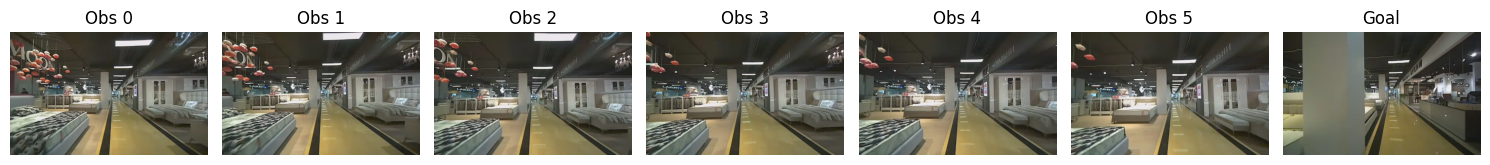

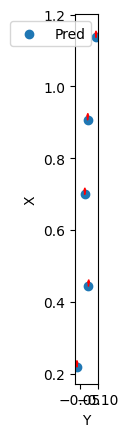

In [6]:
item = ds[np.random.randint(0, len(ds))]
num_obs = len(item["obs"])

fig, axes = plt.subplots(1, num_obs + 1, figsize=(15, 5))
for i in range(num_obs):
    axes[i].imshow(item["obs"][i])
    axes[i].set_title(f"Obs {i}")
    axes[i].axis('off')

axes[-1].imshow(item["goal"])
axes[-1].set_title("Goal")
axes[-1].axis('off')

plt.tight_layout()
plt.show()

traj = item["action"].numpy()

plt.figure()
ax = plt.gca()
ax.set_aspect('equal', 'box')
ax.invert_xaxis()
ax.scatter(x=traj[:, 1], y=traj[:, 0], label="Pred")

# Add arrows to show direction based on the angle (traj[:, 2])
for i in range(len(traj)):
    angle = traj[i, 2]
    # Calculate arrow direction components
    dx = np.cos(angle) * 0.01  # Scale arrow length
    dy = np.sin(angle) * 0.01
    # Draw arrow at each trajectory point
    ax.arrow(traj[i, 1], traj[i, 0], dy, dx, 
             head_width=0.005, head_length=0.008, fc='red', ec='red')

ax.set_xlabel("Y")
ax.set_ylabel("X")
plt.legend()
plt.show()


In [7]:
ds2 = GNMDataset(index=gnm_index,
                 root=NEW_ROOT,
                 features=[GNMRGBFeature(name="obs",
                                        field="obs"),
                            GNMDepthFeature(name="obs_depth",
                                            field="obs",
                                            indices=-1),
                            GNMRGBFeature(name="goal",
                                          field="goal"),
                            GNMWaypointFeature(name="action",
                                               angle_format="sincos")])

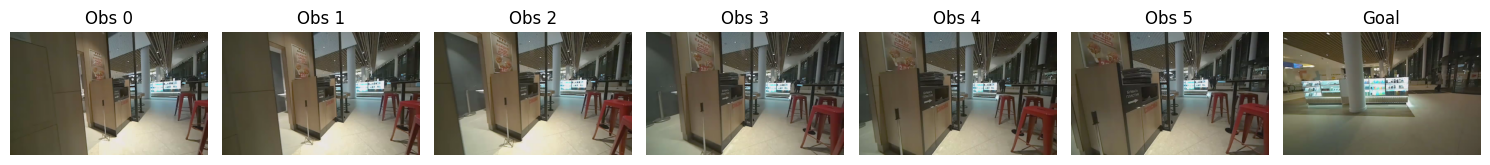

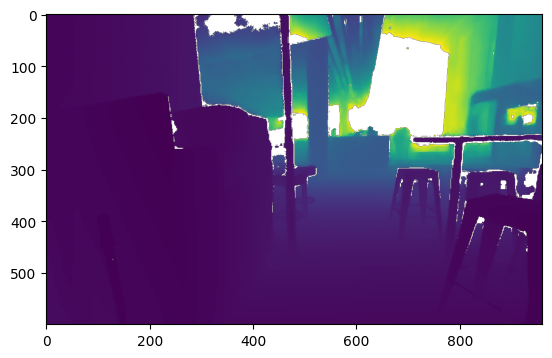

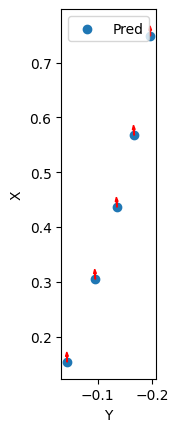

In [8]:
item = ds2[np.random.randint(0, len(ds))]
num_obs = len(item["obs"])

fig, axes = plt.subplots(1, num_obs + 1, figsize=(15, 5))
for i in range(num_obs):
    axes[i].imshow(item["obs"][i])
    axes[i].set_title(f"Obs {i}")
    axes[i].axis('off')

axes[-1].imshow(item["goal"])
axes[-1].set_title("Goal")
axes[-1].axis('off')

plt.tight_layout()
plt.show()


plt.figure()
plt.imshow(item["obs_depth"])
plt.show()

traj = item["action"].numpy()

plt.figure()
ax = plt.gca()
ax.set_aspect('equal', 'box')
ax.invert_xaxis()
ax.scatter(x=traj[:, 1], y=traj[:, 0], label="Pred")

# Add arrows to show direction based on the angle (traj[:, 2])
for i in range(len(traj)):
    angle = traj[i, 2]
    # Calculate arrow direction components
    dx = np.cos(angle) * 0.01  # Scale arrow length
    dy = np.sin(angle) * 0.01
    # Draw arrow at each trajectory point
    ax.arrow(traj[i, 1], traj[i, 0], dy, dx, 
             head_width=0.005, head_length=0.008, fc='red', ec='red')

ax.set_xlabel("Y")
ax.set_ylabel("X")
plt.legend()
plt.show()
